# 🌍 ST-CDGM Training & Evaluation Notebook
## Spatio-Temporal Causal Diffusion Generative Model

Ce notebook vous permet de :
1. **Explorer les données** climatiques NetCDF
2. **Entraîner le modèle** ST-CDGM
3. **Tester et évaluer** les performances
4. **Visualiser les résultats** de downscaling


## 🎯 Motivation et Idée Centrale

### 💡 **Motivation**
Remplacer le bruit statistique aléatoire par un **signal physique** généré causalement

### 🔬 **Idée**
Utiliser la causalité pour générer les **détails fins** (incertitudes)

---

**Concept clé du ST-CDGM** : Au lieu d'utiliser du bruit gaussien purement aléatoire comme les modèles de diffusion classiques, le ST-CDGM génère les détails haute résolution en exploitant les relations causales entre les variables climatiques. Cela permet de produire des prédictions physiquement cohérentes et réalistes.


## 📦 1. Installation et Imports


In [1]:
# Installation des dépendances et du package st_cdgm (exécuter cette cellule une fois si besoin)
# Assurez-vous d'être à la racine du projet (répertoire contenant requirements.txt et setup.py)

#!pip install -r requirements.txt
#!pip install -e .

#print("✅ Dépendances et package st_cdgm installés. Redémarrez le noyau si nécessaire.")


### Installation PyTorch avec support GPU (optionnel)

Pour utiliser les 4 GPUs et le Mixed Precision, installez PyTorch avec CUDA. Exécutez **une seule** des commandes ci-dessous dans un terminal (selon votre version CUDA, vérifiez avec `nvidia-smi`), puis redémarrez le noyau.

- **CUDA 11.8** :
  ```bash
  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  ```
- **CUDA 12.1** :
  ```bash
  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
  ```

Ensuite, installez PyTorch Geometric (build compatible avec votre version de PyTorch/CUDA) :
  ```bash
  pip install torch-geometric torch-scatter torch-sparse
  ```

In [2]:
# Configuration complète pour exécution locale
# Auto-reload des modules locaux (utile si vous modifiez le code dans src/ pendant la session)
%load_ext autoreload
%autoreload 2

import os
import sys                              
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Définir le répertoire de travail
project_root = Path.cwd()
os.chdir(project_root)

# Ajouter src au PYTHONPATH
if str(project_root / "src") not in sys.path:
    sys.path.insert(0, str(project_root / "src"))

# Imports scientifiques
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # Pour CenteredNorm (centrage de colormap)
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Imports depuis le package st_cdgm
from st_cdgm import (
    NetCDFDataPipeline,
    HeteroGraphBuilder,
    IntelligibleVariableEncoder,
    RCNCell,
    RCNSequenceRunner,
    CausalDiffusionDecoder,
    train_epoch,
)

# Pour IntelligibleVariableConfig (si nécessaire)
from st_cdgm.models.intelligible_encoder import IntelligibleVariableConfig

# Métriques d'évaluation (structure spatiale, extrêmes, variabilité temporelle)
from st_cdgm.evaluation import (
    compute_f1_extremes,
    compute_spectrum_distance,
    compute_fss,
    compute_temporal_variance_metrics,
)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Vérifications
print(f"✅ Répertoire de travail: {os.getcwd()}")
print(f"✅ PYTHONPATH configuré: {str(project_root / 'src') in sys.path}")
print(f"✅ Package st_cdgm disponible: {Path('src/st_cdgm').exists()}")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"✅ Tous les imports réussis")


✅ Répertoire de travail: /data-store/iplant/home/alainbomgni1/analyses/stcdgm
✅ PYTHONPATH configuré: True
✅ Package st_cdgm disponible: True
✅ PyTorch version: 2.1.1+cpu
✅ Device: CPU
✅ Tous les imports réussis


In [ ]:
# Vérification de l'environnement (CUDA, GPUs, dépendances)
import torch

print("=== Vérification environnement ===\n")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Version CUDA (PyTorch): {torch.version.cuda}")
    n_devices = torch.cuda.device_count()
    print(f"Nombre de GPUs: {n_devices}")
    if n_devices < 4:
        print(f"  [ATTENTION] Multi-GPU config attend 4 GPUs; vous en avez {n_devices}.")
    for i in range(n_devices):
        print(f"  - GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("  [INFO] Pas de CUDA. L'entraînement utilisera le CPU (plus lent).")
    print("  Pour activer le GPU, installez PyTorch avec CUDA (voir cellule ci-dessus).")

try:
    import xbatcher
    print(f"\nxbatcher: OK")
except ImportError:
    print("\nxbatcher: MANQUANT (pip install xbatcher)")

try:
    import torch_geometric
    print(f"torch_geometric: OK")
except ImportError:
    print("torch_geometric: MANQUANT (pip install torch-geometric)")

print("\n=== Fin vérification ===")

In [3]:
# Configuration complète pour exécution locale
# Auto-reload des modules locaux (utile si vous modifiez le code dans src/ pendant la session)
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Définir le répertoire de travail
project_root = Path.cwd()
os.chdir(project_root)

# Ajouter src au PYTHONPATH
if str(project_root / "src") not in sys.path:
    sys.path.insert(0, str(project_root / "src"))

# Imports scientifiques
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # Pour CenteredNorm (centrage de colormap)
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Imports depuis le package st_cdgm
from st_cdgm import (
    NetCDFDataPipeline,
    HeteroGraphBuilder,
    IntelligibleVariableEncoder,
    RCNCell,
    RCNSequenceRunner,
    CausalDiffusionDecoder,
    train_epoch,
)

# Pour IntelligibleVariableConfig (si nécessaire)
from st_cdgm.models.intelligible_encoder import IntelligibleVariableConfig

# Métriques d'évaluation (structure spatiale, extrêmes, variabilité temporelle)
from st_cdgm.evaluation import (
    compute_f1_extremes,
    compute_spectrum_distance,
    compute_fss,
    compute_temporal_variance_metrics,
)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Vérifications
print(f"✅ Répertoire de travail: {os.getcwd()}")
print(f"✅ PYTHONPATH configuré: {str(project_root / 'src') in sys.path}")
print(f"✅ Package st_cdgm disponible: {Path('src/st_cdgm').exists()}")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"✅ Tous les imports réussis")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Répertoire de travail: /data-store/iplant/home/alainbomgni1/analyses/stcdgm
✅ PYTHONPATH configuré: True
✅ Package st_cdgm disponible: True
✅ PyTorch version: 2.1.1+cpu
✅ Device: CPU
✅ Tous les imports réussis


In [4]:
# Configuration complète pour exécution locale
# Auto-reload des modules locaux (utile si vous modifiez le code dans src/ pendant la session)
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Définir le répertoire de travail
project_root = Path.cwd()
os.chdir(project_root)

# Ajouter src au PYTHONPATH
if str(project_root / "src") not in sys.path:
    sys.path.insert(0, str(project_root / "src"))

# Imports scientifiques
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # Pour CenteredNorm (centrage de colormap)
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Imports depuis le package st_cdgm
from st_cdgm import (
    NetCDFDataPipeline,
    HeteroGraphBuilder,
    IntelligibleVariableEncoder,
    RCNCell,
    RCNSequenceRunner,
    CausalDiffusionDecoder,
    train_epoch,
)

# Pour IntelligibleVariableConfig (si nécessaire)
from st_cdgm.models.intelligible_encoder import IntelligibleVariableConfig

# Métriques d'évaluation (structure spatiale, extrêmes, variabilité temporelle)
from st_cdgm.evaluation import (
    compute_f1_extremes,
    compute_spectrum_distance,
    compute_fss,
    compute_temporal_variance_metrics,
)

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Vérifications
print(f"✅ Répertoire de travail: {os.getcwd()}")
print(f"✅ PYTHONPATH configuré: {str(project_root / 'src') in sys.path}")
print(f"✅ Package st_cdgm disponible: {Path('src/st_cdgm').exists()}")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"✅ Tous les imports réussis")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Répertoire de travail: /data-store/iplant/home/alainbomgni1/analyses/stcdgm
✅ PYTHONPATH configuré: True
✅ Package st_cdgm disponible: True
✅ PyTorch version: 2.1.1+cpu
✅ Device: CPU
✅ Tous les imports réussis


### 2.1.1 📦 Preprocessing Zarr (exécuter une fois)

**Étape optionnelle mais recommandée** : Convertir les données NetCDF en format Zarr optimisé pour éviter les erreurs HDF et améliorer les performances I/O.

In [ ]:
# Preprocessing automatique selon le format configuré
from pathlib import Path
import subprocess
import sys
import json

# Lire le format de données depuis la configuration
DATASET_FORMAT = CONFIG.data.get("dataset_format", "zarr").lower()
print(f"📋 Format de données configuré: {DATASET_FORMAT}")

# Répertoires de sortie pour les données préprocessées
ZARR_DIR = Path(CONFIG.data.get("zarr_dir", "data/raw/train/zarr"))
SHARD_DIR = Path(CONFIG.data.get("shard_dir", "data/raw/train/shards"))

# Fonction pour vérifier si les données Zarr existent
def check_zarr_exists():
    return (ZARR_DIR / "lr.zarr").exists() and (ZARR_DIR / "hr.zarr").exists()

# Fonction pour vérifier si les shards existent
def check_shards_exist():
    return SHARD_DIR.exists() and (SHARD_DIR / "metadata.json").exists() and len(list(SHARD_DIR.glob("*.tar"))) > 0

# Fonction pour préprocesser vers Zarr
def preprocess_to_zarr():
    print("🔄 Conversion NetCDF → Zarr...")
    print(f"   Sortie: {ZARR_DIR}")
    
    cmd = [
        sys.executable, "-m", "ops.preprocess_to_zarr",
        "--lr_path", str(CONFIG.data.lr_path),
        "--hr_path", str(CONFIG.data.hr_path),
        "--output_dir", str(ZARR_DIR),
        "--seq_len", str(CONFIG.data.seq_len),
        "--baseline_strategy", CONFIG.data.baseline_strategy,
        "--baseline_factor", str(CONFIG.data.get("baseline_factor", 4)),
        "--chunk_size_time", "100",  # Optimisé pour 64 CPUs
        "--chunk_size_lat", "64",
        "--chunk_size_lon", "64",
    ]
    
    if CONFIG.data.get("normalize", False):
        cmd.append("--normalize")
    if CONFIG.data.get("static_path"):
        cmd.extend(["--static_path", str(CONFIG.data.static_path)])
    if CONFIG.data.get("lr_variables"):
        cmd.extend(["--lr_variables"] + list(CONFIG.data.lr_variables))
    if CONFIG.data.get("hr_variables"):
        cmd.extend(["--hr_variables"] + list(CONFIG.data.hr_variables))
    if CONFIG.data.get("static_variables"):
        cmd.extend(["--static_variables"] + list(CONFIG.data.static_variables))
    
    try:
        subprocess.run(cmd, check=True)
        print(f"\n✅ Conversion Zarr terminée! Données disponibles dans: {ZARR_DIR}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Erreur lors de la conversion Zarr: {e}")
        raise

# Fonction pour préprocesser vers Shards
def preprocess_to_shards():
    print("🔄 Conversion NetCDF → WebDataset Shards...")
    print(f"   Sortie: {SHARD_DIR}")
    
    cmd = [
        sys.executable, "-m", "ops.preprocess_to_shards",
        "--lr_path", str(CONFIG.data.lr_path),
        "--hr_path", str(CONFIG.data.hr_path),
        "--output_dir", str(SHARD_DIR),
        "--seq_len", str(CONFIG.data.seq_len),
        "--baseline_strategy", CONFIG.data.baseline_strategy,
        "--baseline_factor", str(CONFIG.data.get("baseline_factor", 4)),
        "--samples_per_shard", "100",  # Optimisé pour streaming
    ]
    
    if CONFIG.data.get("normalize", False):
        cmd.append("--normalize")
    if CONFIG.data.get("static_path"):
        cmd.extend(["--static_path", str(CONFIG.data.static_path)])
    if CONFIG.data.get("lr_variables"):
        cmd.extend(["--lr_variables"] + list(CONFIG.data.lr_variables))
    if CONFIG.data.get("hr_variables"):
        cmd.extend(["--hr_variables"] + list(CONFIG.data.hr_variables))
    if CONFIG.data.get("static_variables"):
        cmd.extend(["--static_variables"] + list(CONFIG.data.static_variables))
    
    try:
        subprocess.run(cmd, check=True)
        print(f"\n✅ Conversion Shards terminée! Données disponibles dans: {SHARD_DIR}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Erreur lors de la conversion Shards: {e}")
        raise

# Logique de sélection et de génération automatique
if DATASET_FORMAT == "netcdf":
    print("✅ Mode NetCDF: Lecture directe des fichiers .nc")
    PIPELINE_MODE = "netcdf"
    
elif DATASET_FORMAT == "zarr":
    if check_zarr_exists():
        print(f"✅ Données Zarr déjà présentes dans: {ZARR_DIR}")
        PIPELINE_MODE = "zarr"
    else:
        print(f"⚠️  Données Zarr non trouvées dans: {ZARR_DIR}")
        print("   Génération automatique...")
        preprocess_to_zarr()
        PIPELINE_MODE = "zarr"
        
elif DATASET_FORMAT == "shard":
    if check_shards_exist():
        print(f"✅ Shards WebDataset déjà présents dans: {SHARD_DIR}")
        PIPELINE_MODE = "shard"
    else:
        print(f"⚠️  Shards non trouvés dans: {SHARD_DIR}")
        print("   Génération automatique...")
        preprocess_to_shards()
        PIPELINE_MODE = "shard"
else:
    raise ValueError(f"Format de données non reconnu: {DATASET_FORMAT}. Utilisez 'netcdf', 'zarr', ou 'shard'.")

print(f"\n🎯 Mode de pipeline actif: {PIPELINE_MODE}")

In [5]:
# Charger la configuration depuis config/training_config.yaml (source unique de vérité)
from omegaconf import OmegaConf

CONFIG = OmegaConf.load("config/training_config.yaml")
print("Config chargée depuis config/training_config.yaml")
print(f"  - Device: {CONFIG.training.device}")
print(f"  - Epochs: {CONFIG.training.epochs}")
print(f"  - Lambda gen: {CONFIG.loss.lambda_gen}, Beta rec: {CONFIG.loss.beta_rec}, Gamma DAG: {CONFIG.loss.gamma_dag}")

Config chargée depuis config/training_config.yaml
  - Device: cpu
  - Epochs: 10
  - Lambda gen: 1.0, Beta rec: 0.1, Gamma DAG: 0.1


## 🗂️ 2. Exploration des Données

### 2.1 Configuration des chemins


In [6]:
# Chemins relatifs depuis le répertoire du projet
# Structure data/ : raw/train/ (entraînement), raw/normalization_coefs/, raw/static_predictors/, raw/*.nc (test/eval)
from pathlib import Path
# Chemins depuis CONFIG (config/training_config.yaml)
DATA_ROOT = Path("data/raw")
LR_PATH = str(CONFIG.data.lr_path)
HR_PATH = str(CONFIG.data.hr_path)
STATIC_PATH = str(CONFIG.data.static_path) if CONFIG.data.get("static_path") else None
MEAN_PATH = str(DATA_ROOT / "normalization_coefs" / "mean_1974_2011.nc")
STD_PATH = str(DATA_ROOT / "normalization_coefs" / "std_1974_2011.nc")
URL_ZENODO_HR = "https://zenodo.org/records/10889046/files/pr_ACCESS-CM2_hist.nc?download=1"
URL_ZENODO_LR = "https://zenodo.org/records/10889046/files/predictor_ACCESS-CM2_hist.nc?download=1"

# Vérifier l'existence des fichiers
# from pathlib import Path
# import urllib.request

# if not os.path.exists(HR_PATH):
#     print("⏳ Téléchargement du dataset HR depuis Zenodo...")
#     os.makedirs("data/raw", exist_ok=True)
#     urllib.request.urlretrieve(URL_ZENODO_HR, HR_PATH)
#     print("✅ Téléchargement HR terminé.")

# if not os.path.exists(LR_PATH):
#     print("⏳ Téléchargement du dataset HR depuis Zenodo...")
#     os.makedirs("data/raw", exist_ok=True)
#     urllib.request.urlretrieve(URL_ZENODO_LR, LR_PATH)
#     print("✅ Téléchargement LR terminé.")


for path, name in [(LR_PATH, "LR"), (HR_PATH, "HR")]:
    if path and Path(path).exists():
        print(f"✅ {name} dataset trouvé: {path}")
    else:
        print(f"❌ {name} dataset manquant: {path}")

# Vérifier STATIC_PATH, MEAN_PATH, STD_PATH
for path, name in [(STATIC_PATH, "Static"), (MEAN_PATH, "Mean"), (STD_PATH, "Std")]:
    if path and Path(path).exists():
        print(f"✅ {name} trouvé: {path}")
    else:
        print(f"❌ {name} manquant: {path}")
if not Path(STATIC_PATH).exists():
    STATIC_PATH = None
if not Path(MEAN_PATH).exists():
    MEAN_PATH = None
if not Path(STD_PATH).exists():
    STD_PATH = None

# Afficher la structure data/raw/
data_dir = Path("data/raw")
if data_dir.exists():
    print(f"\n📁 Structure data/raw/:")
    for sub in sorted(data_dir.iterdir()):
        if sub.is_dir():
            files = list(sub.glob("*.nc")) or list(sub.glob("*.json")) or []
            print(f"   {sub.name}/: {[f.name for f in files[:5]]}{'...' if len(files) > 5 else ''}")
        else:
            print(f"   {sub.name}")
else:
    print(f"\n⚠️  Répertoire data/raw/ n'existe pas")


✅ LR dataset trouvé: data/raw/train/predictor_ACCESS-CM2_hist.nc
✅ HR dataset trouvé: data/raw/train/pr_ACCESS-CM2_hist.nc
✅ Static trouvé: data/raw/static_predictors/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc
✅ Mean trouvé: data/raw/normalization_coefs/mean_1974_2011.nc
✅ Std trouvé: data/raw/normalization_coefs/std_1974_2011.nc

📁 Structure data/raw/:
   .ipynb_checkpoints/: []
   normalization_coefs/: ['mean_1974_2011.nc', 'std_1974_2011.nc']
   static_predictors/: ['ERA5_eval_ccam_12km.198110_NZ_Invariant.nc']
   test/: ['EC-Earth3_historical_precip_compressed.nc', 'EC-Earth3_histupdated_compressed.nc', 'NorESM2-MM_historical_precip_compressed.nc', 'NorESM2-MM_histupdated_compressed.nc']
   train/: ['pr_ACCESS-CM2_hist.nc', 'predictor_ACCESS-CM2_hist.nc']


In [7]:
import sys
import subprocess
import importlib

try:
    import xbatcher
except ImportError:
    print("Installing xbatcher...")
    # FIX: Use subprocess.run with check=True
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "xbatcher"], 
        check=True, 
        capture_output=False # This argument works with .run()
    )
    
    import st_cdgm.data.pipeline as _pipe
    importlib.reload(_pipe)
    print("xbatcher installed and pipeline module reloaded. Proceeding.")

### 2.2 Chargement et inspection des données brutes


In [9]:
# Charger les datasets bruts
lr_raw = xr.open_dataset(LR_PATH)
hr_raw = xr.open_dataset(HR_PATH)

print("=" * 60)
print("📊 LOW RESOLUTION DATASET")
print("=" * 60)
print(lr_raw)
print("\n" + "=" * 60)
print("📊 HIGH RESOLUTION DATASET")
print("=" * 60)
print(hr_raw)


📊 LOW RESOLUTION DATASET
<xarray.Dataset> Size: 720MB
Dimensions:  (time: 20075, lat: 23, lon: 26, lev: 3)
Coordinates:
  * time     (time) object 161kB 1960-01-01 00:00:00 ... 2014-12-31 00:00:00
  * lat      (lat) float64 184B -59.38 -57.88 -56.38 ... -29.38 -27.88 -26.38
  * lon      (lon) float64 208B 150.6 152.1 153.6 155.1 ... 185.1 186.6 188.1
  * lev      (lev) float32 12B 850.0 500.0 250.0
Data variables: (12/15)
    u_850    (time, lat, lon) float32 48MB ...
    u_500    (time, lat, lon) float32 48MB ...
    u_250    (time, lat, lon) float32 48MB ...
    v_850    (time, lat, lon) float32 48MB ...
    v_500    (time, lat, lon) float32 48MB ...
    v_250    (time, lat, lon) float32 48MB ...
    ...       ...
    q_850    (time, lat, lon) float32 48MB ...
    q_500    (time, lat, lon) float32 48MB ...
    q_250    (time, lat, lon) float32 48MB ...
    t_850    (time, lat, lon) float32 48MB ...
    t_500    (time, lat, lon) float32 48MB ...
    t_250    (time, lat, lon) float32 4

In [10]:
# Informations sur les dimensions
def print_dataset_info(ds, name):
    print(f"\n{'='*50}")
    print(f"📐 {name} DATASET INFO")
    print(f"{'='*50}")
    print(f"Variables: {list(ds.data_vars)}")
    print(f"Dimensions: {dict(ds.dims)}")
    print(f"Coordinates: {list(ds.coords)}")
    if 'time' in ds.dims or 'time' in ds.coords:
        time_coord = 'time' if 'time' in ds.coords else list(ds.coords)[0]
        try:
            # Gérer différents types de coordonnées temporelles
            time_values = ds[time_coord].values
            if hasattr(time_values[0], 'strftime'):  # datetime object
                start_time = time_values[0]
                end_time = time_values[-1]
            else:  # string ou autre format
                start_time = pd.to_datetime(str(time_values[0]))
                end_time = pd.to_datetime(str(time_values[-1]))
            print(f"Période: {start_time} → {end_time}")
            print(f"Nombre de pas de temps: {len(ds[time_coord])}")
        except Exception as e:
            # En cas d'erreur, afficher les valeurs brutes
            print(f"Coordonnées temporelles: {ds[time_coord].values[0]} → {ds[time_coord].values[-1]}")
            print(f"Nombre de pas de temps: {len(ds[time_coord])}")

print_dataset_info(lr_raw, "LOW RESOLUTION")
print_dataset_info(hr_raw, "HIGH RESOLUTION")



📐 LOW RESOLUTION DATASET INFO
Variables: ['u_850', 'u_500', 'u_250', 'v_850', 'v_500', 'v_250', 'w_850', 'w_500', 'w_250', 'q_850', 'q_500', 'q_250', 't_850', 't_500', 't_250']
Dimensions: {'time': 20075, 'lat': 23, 'lon': 26, 'lev': 3}
Coordinates: ['lon', 'lat', 'lev', 'time']
Période: 1960-01-01 00:00:00 → 2014-12-31 00:00:00
Nombre de pas de temps: 20075

📐 HIGH RESOLUTION DATASET INFO
Variables: ['u_850', 'u_500', 'u_250', 'v_850', 'v_500', 'v_250', 'w_850', 'w_500', 'w_250', 'q_850', 'q_500', 'q_250', 't_850', 't_500', 't_250']
Dimensions: {'time': 20075, 'lat': 23, 'lon': 26, 'lev': 3}
Coordinates: ['lon', 'lat', 'lev', 'time']
Période: 1960-01-01 00:00:00 → 2014-12-31 00:00:00
Nombre de pas de temps: 20075


### 2.3 Visualisation des données


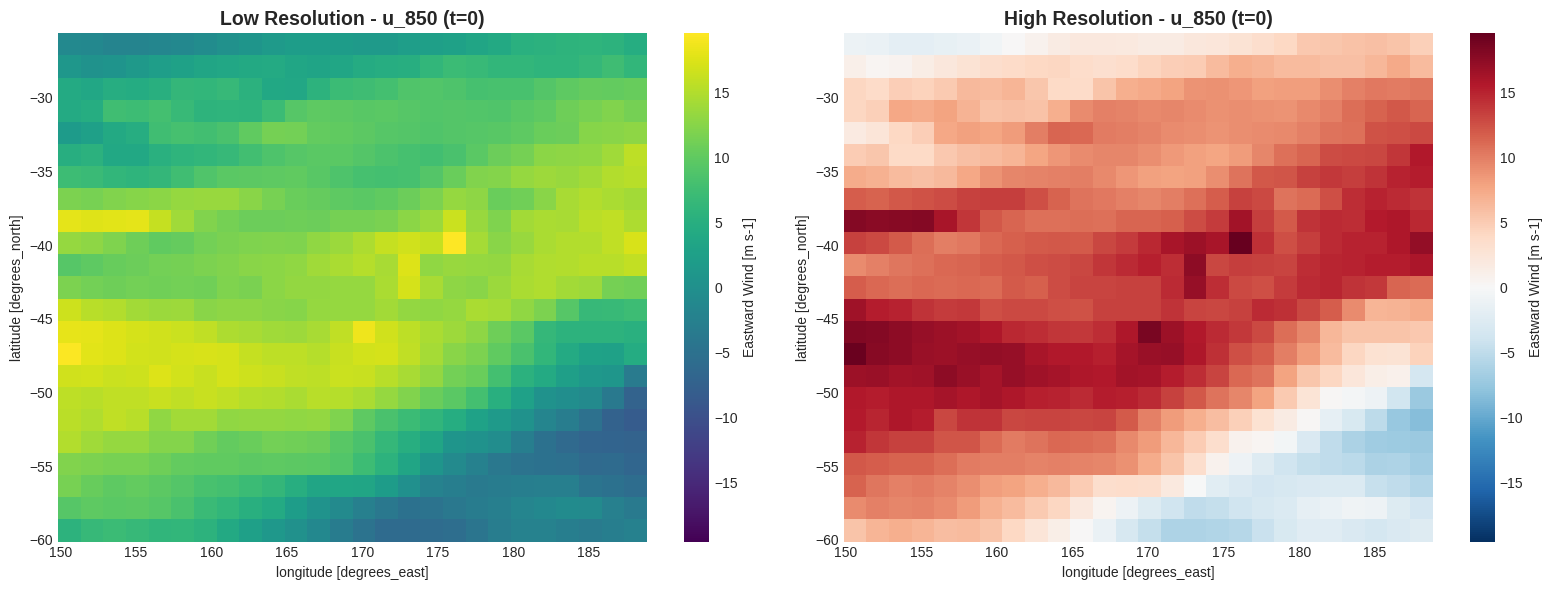

In [11]:
# Visualiser un snapshot des données LR et HR
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LR data
lr_var = list(lr_raw.data_vars)[0]
lr_raw[lr_var].isel(time=0).plot(ax=axes[0], cmap='viridis')
axes[0].set_title(f'Low Resolution - {lr_var} (t=0)', fontsize=14, fontweight='bold')

# HR data
hr_var = list(hr_raw.data_vars)[0]
hr_raw[hr_var].isel(time=0).plot(ax=axes[1], cmap='RdBu_r')
axes[1].set_title(f'High Resolution - {hr_var} (t=0)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 2.4 Création du pipeline de données


In [12]:
  
# Configuration du pipeline depuis CONFIG (config/training_config.yaml)
SEQ_LEN = CONFIG.data.seq_len
BASELINE_STRATEGY = CONFIG.data.baseline_strategy
BASELINE_FACTOR = CONFIG.data.baseline_factor
NORMALIZE = CONFIG.data.normalize
PRECIPITATION_DELTA = CONFIG.data.precipitation_delta
NAN_FILL_STRATEGY = CONFIG.data.nan_fill_strategy

# Options d'évaluation (structure spatiale, extrêmes)
FSS_THRESHOLD_PERCENTILE = 95.0  # Seuil FSS (percentile de la cible)
F1_PERCENTILES = [95.0, 99.0]  # Percentiles pour F1 extrêmes
FSS_WINDOW_SIZE = 9  # Taille fenêtre FSS (impair)

# Variables: CONFIG peut être null → fallback comme downscaling
_default_lr = ["q_500", "q_850", "u_500", "u_850", "v_500", "v_850", "t_500", "t_850"]
_default_hr = ["pr"]
LR_VARIABLES = list(CONFIG.data.lr_variables) if CONFIG.data.get("lr_variables") else _default_lr
HR_VARIABLES = list(CONFIG.data.hr_variables) if CONFIG.data.get("hr_variables") else _default_hr
STATIC_VARIABLES = list(CONFIG.data.static_variables) if CONFIG.data.get("static_variables") else (["orog", "he", "vegt"] if STATIC_PATH else None)

# Sécurité: afficher les chemins réellement utilisés
print(f"LR_PATH actif: {LR_PATH}")
print(f"HR_PATH actif: {HR_PATH}")
print(f"STATIC_PATH: {STATIC_PATH}")
print(f"MEAN_PATH: {MEAN_PATH}, STD_PATH: {STD_PATH}")

# Valider que les variables existent, sinon fallback automatique
import xarray as xr
lr_ds_preview = xr.open_dataset(LR_PATH)
hr_ds_preview = xr.open_dataset(HR_PATH)

lr_avail = set(lr_ds_preview.data_vars)
hr_avail = set(hr_ds_preview.data_vars)

if not set(LR_VARIABLES).issubset(lr_avail):
    print(f"⚠️  LR_VARIABLES invalides: {set(LR_VARIABLES) - lr_avail}")
    LR_VARIABLES = [v for v in LR_VARIABLES if v in lr_avail] or sorted(lr_avail)[:8]
    print(f"➡️  Fallback LR_VARIABLES = {LR_VARIABLES}")

if not set(HR_VARIABLES).issubset(hr_avail):
    print(f"⚠️  HR_VARIABLES invalides: {set(HR_VARIABLES) - hr_avail}")
    HR_VARIABLES = [sorted(hr_avail)[0]]
    print(f"➡️  Fallback HR_VARIABLES = {HR_VARIABLES}")

print("🔄 Création du pipeline de données...")

# Sélection du pipeline selon le format de données configuré
if PIPELINE_MODE == "zarr":
    print("   Mode: ZarrDataPipeline (I/O optimisé, chunks, compression LZ4)")
    from st_cdgm.data.pipeline import ZarrDataPipeline
    
    pipeline = ZarrDataPipeline(
        zarr_dir=str(ZARR_DIR),
        seq_len=SEQ_LEN,
        stride=CONFIG.data.get("stride", 1),
    )
    
    print("\n✅ ZarrDataPipeline créé avec succès!")
    print(f"   - LR shape: {pipeline.lr_dataset.dims}")
    print(f"   - HR shape: {pipeline.hr_dataset.dims}")
    print(f"   - Residual shape: {pipeline.residual_dataset.dims}")
    
elif PIPELINE_MODE == "shard":
    print("   Mode: WebDatasetDataPipeline (streaming haute performance)")
    from st_cdgm.data.pipeline import WebDatasetDataPipeline
    
    pipeline = WebDatasetDataPipeline(
        shard_dir=str(SHARD_DIR),
        shuffle=CONFIG.data.get("shuffle", False),
        shardshuffle=100,
        shuffle_buffer_size=1000,
    )
    
    print("\n✅ WebDatasetDataPipeline créé avec succès!")
    print(f"   - Shard directory: {SHARD_DIR}")
    print(f"   - Sequence length: {pipeline.seq_len}")
    
elif PIPELINE_MODE == "netcdf":
    print("   Mode: NetCDFDataPipeline (lecture directe des fichiers .nc)")
    from st_cdgm.data.pipeline import NetCDFDataPipeline
    
    pipeline = NetCDFDataPipeline(
        lr_path=LR_PATH,
        hr_path=HR_PATH,
        static_path=STATIC_PATH,
        seq_len=SEQ_LEN,
        baseline_strategy=BASELINE_STRATEGY,
        baseline_factor=BASELINE_FACTOR,
        normalize=NORMALIZE,
        nan_fill_strategy=NAN_FILL_STRATEGY,
        precipitation_delta=PRECIPITATION_DELTA,
        lr_variables=LR_VARIABLES,
        hr_variables=HR_VARIABLES,
        static_variables=STATIC_VARIABLES,
        means_path=MEAN_PATH if (MEAN_PATH and os.path.exists(MEAN_PATH)) else None,
        stds_path=STD_PATH if (STD_PATH and os.path.exists(STD_PATH)) else None,
    )
    
    print("\n✅ NetCDFDataPipeline créé avec succès!")
    print(f"   - LR shape: {pipeline.lr_dataset.dims}")
    print(f"   - HR shape: {pipeline.hr_dataset.dims}")
    print(f"   - Residual shape: {pipeline.residual_dataset.dims}")
    
else:
    raise ValueError(f"Mode de pipeline inconnu: {PIPELINE_MODE}")


LR_PATH actif: data/raw/train/predictor_ACCESS-CM2_hist.nc
HR_PATH actif: data/raw/train/pr_ACCESS-CM2_hist.nc
STATIC_PATH: data/raw/static_predictors/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc
MEAN_PATH: data/raw/normalization_coefs/mean_1974_2011.nc, STD_PATH: data/raw/normalization_coefs/std_1974_2011.nc
⚠️  HR_VARIABLES invalides: {'pr'}
➡️  Fallback HR_VARIABLES = ['q_250']
🔄 Création du pipeline de données...

✅ Pipeline créé avec succès!
   - LR shape: FrozenMappingWarningOnValuesAccess({'time': 20075, 'lat': 23, 'lon': 26})
   - HR shape: FrozenMappingWarningOnValuesAccess({'time': 20075, 'lat': 23, 'lon': 26})
   - Residual shape: FrozenMappingWarningOnValuesAccess({'lon': 26, 'lat': 23, 'time': 20075})


### 2.6 Config test (jeux tenus à l'écart)

Configuration des chemins et GCMs pour l'évaluation sur données de test (comme downscaling : un jeu par GCM dans `data/raw/test/`).

In [13]:
# Config test : chemins et GCMs (comme downscaling eval_predictor_variables + ground_truth)
TEST_ROOT = Path("data/raw/test")

# Détection des GCMs de test à partir des fichiers présents (convention: {GCM}_histupdated_compressed.nc, {GCM}_historical_precip_compressed.nc)
def _discover_test_gcms():
    if not TEST_ROOT.exists():
        return []
    lr_suffix = "_histupdated_compressed.nc"
    hr_suffix = "_historical_precip_compressed.nc"
    lr_stems = {f.name.replace(lr_suffix, "") for f in TEST_ROOT.glob(f"*{lr_suffix}")}
    hr_stems = {f.name.replace(hr_suffix, "") for f in TEST_ROOT.glob(f"*{hr_suffix}")}
    return sorted(lr_stems & hr_stems)

TEST_GCMs = _discover_test_gcms()
if not TEST_GCMs:
    TEST_GCMs = ["EC-Earth3", "NorESM2-MM"]  # fallback si dossier vide ou absent

def test_lr_path(gcm):
    return str(TEST_ROOT / f"{gcm}_histupdated_compressed.nc")

def test_hr_path(gcm):
    return str(TEST_ROOT / f"{gcm}_historical_precip_compressed.nc")

# Vérifier existence des fichiers pour chaque GCM
print("GCMs de test configurés:", TEST_GCMs)
for gcm in TEST_GCMs:
    lr_ok = Path(test_lr_path(gcm)).exists()
    hr_ok = Path(test_hr_path(gcm)).exists()
    if lr_ok and hr_ok:
        print(f"  OK {gcm}: LR et HR trouvés")
    else:
        print(f"  Manquant {gcm}: LR={lr_ok}, HR={hr_ok}")

GCMs de test configurés: ['EC-Earth3', 'NorESM2-MM']
  OK EC-Earth3: LR et HR trouvés
  OK NorESM2-MM: LR et HR trouvés


In [14]:
def build_test_pipeline(gcm):
    """
    Construit un pipeline de test pour un GCM (même options que le pipeline d'entraînement).
    Retourne NetCDFDataPipeline ou None si les fichiers sont manquants.
    """
    lr_path = test_lr_path(gcm)
    hr_path = test_hr_path(gcm)
    if not Path(lr_path).exists() or not Path(hr_path).exists():
        print(f"  Fichiers test manquants pour {gcm}, skip.")
        return None
    try:
        return NetCDFDataPipeline(
            lr_path=lr_path,
            hr_path=hr_path,
            static_path=STATIC_PATH,
            seq_len=SEQ_LEN,
            baseline_strategy=BASELINE_STRATEGY,
            baseline_factor=BASELINE_FACTOR,
            normalize=NORMALIZE,
            nan_fill_strategy=NAN_FILL_STRATEGY,
            precipitation_delta=PRECIPITATION_DELTA,
            lr_variables=LR_VARIABLES,
            hr_variables=HR_VARIABLES,
            static_variables=STATIC_VARIABLES,
            means_path=MEAN_PATH if (MEAN_PATH and os.path.exists(MEAN_PATH)) else None,
            stds_path=STD_PATH if (STD_PATH and os.path.exists(STD_PATH)) else None,
        )
    except Exception as e:
        print(f"  Erreur build_test_pipeline({gcm}): {e}")
        return None

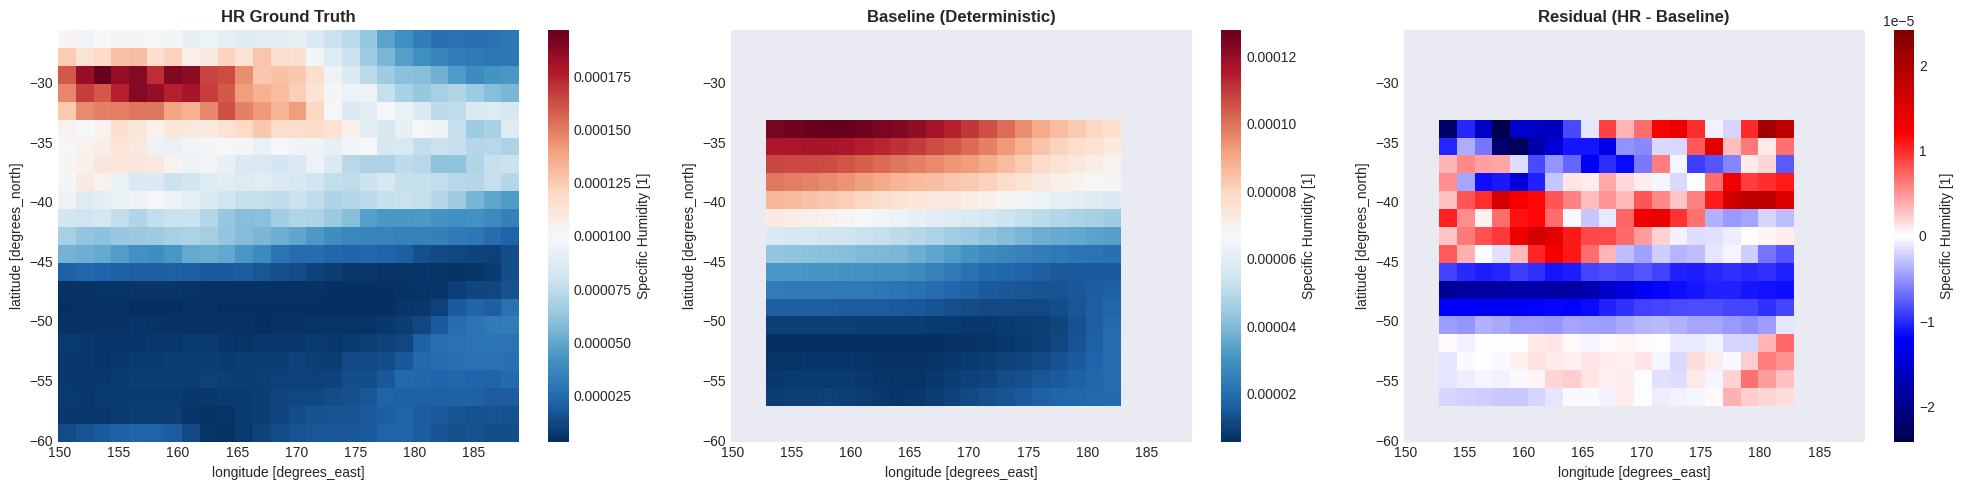

In [15]:
# Visualiser baseline vs HR vs residual
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

time_idx = 0
hr_var = list(pipeline.hr_dataset.data_vars)[0]

# HR truth
pipeline.hr_dataset[hr_var].isel(time=time_idx).plot(ax=axes[0], cmap='RdBu_r')
axes[0].set_title('HR Ground Truth', fontsize=12, fontweight='bold')

# Baseline
pipeline.baseline_prepared[hr_var].isel(time=time_idx).plot(ax=axes[1], cmap='RdBu_r')
axes[1].set_title('Baseline (Deterministic)', fontsize=12, fontweight='bold')

# Residual
pipeline.residual_dataset[hr_var].isel(time=time_idx).plot(ax=axes[2], cmap='seismic', center=0)
axes[2].set_title('Residual (HR - Baseline)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


### 2.5 Création du dataset iterable


In [16]:
# Créer le dataset PyTorch (seq_len, stride depuis CONFIG)
dataset = pipeline.build_sequence_dataset(
    seq_len=SEQ_LEN,
    stride=CONFIG.data.stride,
    as_torch=True,
)

# Inspecter un batch
sample = next(iter(dataset))

print("📦 Structure d'un batch:")
print("=" * 60)
for key, value in sample.items():
    if torch.is_tensor(value):
        print(f"  {key:15s}: shape={tuple(value.shape)}, dtype={value.dtype}")
    else:
        print(f"  {key:15s}: {type(value).__name__}")

print(f"\n✅ Dataset créé avec succès!")
print(f"   Longueur de séquence: {SEQ_LEN}")


📦 Structure d'un batch:
  lr             : shape=(6, 15, 23, 26), dtype=torch.float32
  baseline       : shape=(6, 1, 23, 26), dtype=torch.float32
  residual       : shape=(6, 1, 23, 26), dtype=torch.float32
  hr             : shape=(6, 1, 23, 26), dtype=torch.float32
  time           : ndarray
  static         : shape=(3, 172, 179), dtype=torch.float32

✅ Dataset créé avec succès!
   Longueur de séquence: 6


## 🏗️ 3. Construction du Modèle

### 3.1 Configuration du modèle


In [17]:
# Configuration depuis CONFIG (config/training_config.yaml)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else CONFIG.training.device)

# Dimensions depuis CONFIG.graph (aligné avec le YAML)
lr_shape = tuple(CONFIG.graph.lr_shape)
hr_shape = tuple(CONFIG.graph.hr_shape)

# Dimensions dérivées du sample (dépendent des données)
RCN_DRIVER_DIM = sample["lr"].shape[1]  # Nombre de channels LR
RCN_RECONSTRUCTION_DIM = sample["lr"].shape[1]

# Encoder / RCN / Diffusion (CONFIG.encoder, CONFIG.rcn, CONFIG.diffusion)
HIDDEN_DIM = CONFIG.encoder.hidden_dim
CONDITIONING_DIM = CONFIG.encoder.conditioning_dim
DIFFUSION_STEPS = CONFIG.diffusion.steps

# Hyperparamètres d'entraînement (CONFIG.training, CONFIG.loss)
LEARNING_RATE = CONFIG.training.lr
NUM_EPOCHS = CONFIG.training.epochs
GRADIENT_CLIPPING = CONFIG.training.gradient_clipping
LAMBDA_GEN = CONFIG.loss.lambda_gen
BETA_REC = CONFIG.loss.beta_rec
GAMMA_DAG = CONFIG.loss.gamma_dag

print(f"🖥️  Device: {DEVICE}")
print(f"📐 LR shape: {lr_shape}")
print(f"📐 HR shape: {hr_shape}")
print(f"📐 LR channels: {RCN_DRIVER_DIM}")
print(f"📐 HR channels: {sample['residual'].shape[1]}")


🖥️  Device: cpu
📐 LR shape: (23, 26)
📐 HR shape: (172, 179)
📐 LR channels: 15
📐 HR channels: 1


### 3.2 Construction du graph builder


In [19]:
# Graph builder pour les relations spatiales (CONFIG.graph)
builder = HeteroGraphBuilder(
    lr_shape=lr_shape,
    hr_shape=hr_shape,
    static_dataset=pipeline.get_static_dataset(),
    include_mid_layer=CONFIG.graph.include_mid_layer,
)

print("✅ Graph builder créé")
print(f"   Dynamic node types: {builder.dynamic_node_types}")
print(f"   Static node types: {builder.static_node_types}")


✅ Graph builder créé
   Dynamic node types: ['GP850']
   Static node types: ['SP_HR']


### 3.3 Initialisation des modules du modèle


In [20]:
# 1. Intelligible Variable Encoder (metapaths depuis CONFIG.encoder.metapaths)
# Ne garder que les metapaths dont les nœuds existent dans le graphe (aligné avec include_mid_layer)
allowed_nodes = set(builder.dynamic_node_types) | set(builder.static_node_types)
encoder_configs = [
    IntelligibleVariableConfig(
        name=mp.name,
        meta_path=(mp.src, mp.relation, mp.target),
        pool=mp.get("pool", "mean"),
    )
    for mp in CONFIG.encoder.metapaths
    if mp.src in allowed_nodes and mp.target in allowed_nodes
]
if pipeline.get_static_dataset() is not None:
    encoder_configs.append(
        IntelligibleVariableConfig(
            name="static",
            meta_path=("SP_HR", "causes", "GP850"),
            pool="mean"
        )
    )

encoder = IntelligibleVariableEncoder(
    configs=encoder_configs,
    hidden_dim=HIDDEN_DIM,
    conditioning_dim=CONDITIONING_DIM,
).to(DEVICE)

num_vars = len(encoder_configs)
print(f"✅ Encoder créé avec {num_vars} variables intelligibles")

# 2. Causal RCN
# reconstruction_dim doit égaler driver_dim pour que L_rec compare recon et driver (même forme)
rcn_cell = RCNCell(
    num_vars=num_vars,
    hidden_dim=CONFIG.rcn.hidden_dim,
    driver_dim=RCN_DRIVER_DIM,
    reconstruction_dim=RCN_DRIVER_DIM,
    dropout=CONFIG.rcn.dropout,
).to(DEVICE)

rcn_runner = RCNSequenceRunner(rcn_cell, detach_interval=CONFIG.rcn.get("detach_interval"))
print(f"✅ RCN créé")

# 3. Diffusion Decoder (CONFIG.diffusion; in_channels depuis sample)
hr_channels = sample['residual'].shape[1]

# UNet minimal pour accepter des tailles non multiples de 2^n (ex: 23x26)
UNET_KWARGS = dict(
    layers_per_block=1,
    block_out_channels=(32,),
    down_block_types=("DownBlock2D",),
    up_block_types=("UpBlock2D",),
    norm_num_groups=8,
)

diffusion = CausalDiffusionDecoder(
    in_channels=hr_channels,
    conditioning_dim=CONFIG.diffusion.conditioning_dim,
    height=CONFIG.diffusion.height,
    width=CONFIG.diffusion.width,
    num_diffusion_steps=CONFIG.diffusion.steps,
    unet_kwargs=UNET_KWARGS,
).to(DEVICE)

print(f"✅ Diffusion decoder créé avec {CONFIG.diffusion.steps} steps")

# 4. Optimizer (CONFIG.training.lr)
params = list(encoder.parameters()) + list(rcn_cell.parameters()) + list(diffusion.parameters())
optimizer = torch.optim.Adam(params, lr=CONFIG.training.lr)

print(f"✅ Optimizer créé (lr={CONFIG.training.lr})")

# Compter les paramètres (en gérant les paramètres non initialisés/lazy)
def count_parameters(model):
    """Compte les paramètres d'un modèle, en gérant les paramètres non initialisés."""
    total = 0
    trainable = 0
    for p in model.parameters():
        try:
            num = p.numel()
            total += num
            if p.requires_grad:
                trainable += num
        except (ValueError, RuntimeError):
            # Paramètre non initialisé (lazy module), on l'ignore pour le moment
            pass
    return total, trainable

total_params = 0
trainable_params = 0
for model in [encoder, rcn_cell, diffusion]:
    total, trainable = count_parameters(model)
    total_params += total
    trainable_params += trainable

print(f"\n📊 Nombre de paramètres:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")


✅ Encoder créé avec 2 variables intelligibles
✅ RCN créé
✅ Diffusion decoder créé avec 1000 steps
✅ Optimizer créé (lr=5e-05)

📊 Nombre de paramètres:
   Total: 457,844
   Trainable: 457,844


In [ ]:
# GPU Memory Optimization
if torch.cuda.is_available():
    print("🧹 Optimizing GPU memory management...")
    
    # Clear cache before training to free up fragmented memory
    torch.cuda.empty_cache()
    print("   ✓ GPU cache cleared")
    
    # Set memory allocator to be more aggressive
    # This helps reduce fragmentation and allows using more VRAM
    torch.cuda.set_per_process_memory_fraction(0.95, device=None)  # Use up to 95% of GPU memory
    print("   ✓ Memory fraction set to 0.95 (use up to 95% of VRAM)")
    
    # Display current memory status
    print("\n📊 GPU Memory Status (after model creation):")
    for i in range(torch.cuda.device_count()):
        allocated = torch.cuda.memory_allocated(i) / (1024**3)
        reserved = torch.cuda.memory_reserved(i) / (1024**3)
        total = torch.cuda.get_device_properties(i).total_memory / (1024**3)
        print(f"   GPU {i}: {allocated:.2f} GB allocated / {reserved:.2f} GB reserved / {total:.2f} GB total")
    
    print("\n✅ GPU memory optimization enabled")
else:
    print("ℹ️  No CUDA devices available - skipping GPU memory optimization")

## 🚀 4. Entraînement du Modèle

### 4.1 Fonction helper pour la conversion des batches


In [21]:
def convert_sample_to_batch(sample, builder, device):
    """
    Convertit un échantillon du DataLoader en format attendu par train_epoch.
    """
    lr_seq = sample["lr"]  # [seq_len, channels, lat, lon]
    seq_len = lr_seq.shape[0]
    
    # Convertir grille LR en nodes
    lr_nodes_steps = []
    for t in range(seq_len):
        lr_nodes_steps.append(builder.lr_grid_to_nodes(lr_seq[t]))
    lr_tensor = torch.stack(lr_nodes_steps, dim=0)  # [seq_len, N_lr, channels]
    
    # Préparer hetero data
    dynamic_features = {node_type: lr_nodes_steps[0] for node_type in builder.dynamic_node_types}
    hetero = builder.prepare_step_data(dynamic_features).to(device)
    
    batch = {
        "lr": lr_tensor,
        "residual": sample["residual"],
        "baseline": sample.get("baseline"),
        "hetero": hetero,
    }
    return batch

def iterate_batches(dataloader, builder, device):
    """Générateur qui convertit chaque sample (ou liste) du dataloader."""
    for batch_list in dataloader:
        # Support batch_size > 1: DataLoader yields a list when collate_fn=lambda x: x
        if not isinstance(batch_list, list):
            batch_list = [batch_list]
        
        # Convert each sample in the list to a batch dict
        converted_batches = [convert_sample_to_batch(sample, builder, device) for sample in batch_list]
        
        # Yield the list of converted batches for gradient accumulation
        yield converted_batches


### 4.2 Boucle d'entraînement


In [ ]:
# Multi-GPU Setup (if enabled in config)
from st_cdgm.training.multi_gpu import wrap_models_for_notebook, is_main_process

USE_MULTI_GPU = CONFIG.training.get("multi_gpu", {}).get("enabled", False)

if USE_MULTI_GPU:
    print("🚀 Multi-GPU training enabled")
    print(f"   GPUs: {CONFIG.training.multi_gpu.get('gpus', [0])}")
    
    # Wrap models with DataParallel for notebook environment
    models_dict = {
        'encoder': encoder,
        'rcn_cell': rcn_cell,
        'diffusion': diffusion_model,
    }
    
    wrapped = wrap_models_for_notebook(models_dict, CONFIG)
    encoder = wrapped['encoder']
    rcn_cell = wrapped['rcn_cell']
    diffusion_model = wrapped['diffusion']
    
    # Update optimizer with wrapped models
    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + 
        list(rcn_cell.parameters()) + 
        list(diffusion_model.parameters()),
        lr=CONFIG.training.lr
    )
    
    print("✅ Models wrapped for multi-GPU training")
else:
    print("ℹ️  Single GPU/CPU training mode")

# Rank 0 flag for logging and checkpoints
IS_MAIN_PROCESS = is_main_process()  # Always True in notebook (DataParallel mode)

In [ ]:
# GPU Load Balancing Optimization
if USE_MULTI_GPU:
    import torch.backends.cudnn as cudnn
    
    print("🔧 Configuring GPU load balancing...")
    
    # Enable cuDNN autotuner for optimal convolution algorithms
    cudnn.benchmark = True
    cudnn.enabled = True
    print("   ✓ cuDNN benchmark enabled (finds optimal algorithms)")
    
    # Set optimal thread count per GPU worker
    torch.set_num_threads(4)  # 64 CPUs / 4 GPUs / 4 workers = 4 threads per worker
    print(f"   ✓ PyTorch threads set to {torch.get_num_threads()}")
    
    # Display GPU memory allocation for each GPU
    print("\n📊 GPU Status:")
    for i in CONFIG.training.multi_gpu.get('gpus', [0]):
        if torch.cuda.is_available() and i < torch.cuda.device_count():
            print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
            print(f"      Memory allocated: {torch.cuda.memory_allocated(i)/1e9:.2f} GB")
            print(f"      Memory cached: {torch.cuda.memory_reserved(i)/1e9:.2f} GB")
    
    print("\n✅ GPU load balancing configured")
else:
    print("ℹ️  Single GPU mode - skipping load balancing configuration")

In [ ]:
# Apply torch.compile if enabled (PyTorch 2.0+ optimization)
if CONFIG.training.get("compile", {}).get("enabled", False):
    print("🔧 Compiling models with torch.compile...")
    compile_cfg = CONFIG.training.compile
    
    # Get base models (unwrap from DataParallel if needed)
    encoder_base = encoder.module if hasattr(encoder, 'module') else encoder
    rcn_base = rcn_cell.module if hasattr(rcn_cell, 'module') else rcn_cell
    diffusion_base = diffusion.module if hasattr(diffusion, 'module') else diffusion
    
    # Compile models
    encoder_compiled = torch.compile(encoder_base, mode=compile_cfg.get("encoder_mode", "default"))
    rcn_compiled = torch.compile(rcn_base, mode=compile_cfg.get("rcn_mode", "default"))
    diffusion_compiled = torch.compile(diffusion_base, mode=compile_cfg.get("diffusion_mode", "default"))
    
    # Re-wrap with DataParallel if we had it
    if hasattr(encoder, 'module'):
        encoder = torch.nn.DataParallel(encoder_compiled, device_ids=CONFIG.training.multi_gpu.get('gpus', [0]))
        rcn_cell = torch.nn.DataParallel(rcn_compiled, device_ids=CONFIG.training.multi_gpu.get('gpus', [0]))
        diffusion = torch.nn.DataParallel(diffusion_compiled, device_ids=CONFIG.training.multi_gpu.get('gpus', [0]))
    else:
        encoder = encoder_compiled
        rcn_cell = rcn_compiled
        diffusion = diffusion_compiled
    
    # Re-create optimizer with compiled models
    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(rcn_cell.parameters()) + list(diffusion.parameters()),
        lr=CONFIG.training.lr
    )
    
    print("✅ Models compiled successfully!")
    print(f"   - Encoder mode: {compile_cfg.get('encoder_mode', 'default')}")
    print(f"   - RCN mode: {compile_cfg.get('rcn_mode', 'default')}")
    print(f"   - Diffusion mode: {compile_cfg.get('diffusion_mode', 'default')}")
else:
    print("ℹ️  torch.compile disabled in config")

In [ ]:
# Resource Monitoring Setup
import psutil
import time

def print_resource_usage():
    """Print current CPU, RAM, and GPU resource usage."""
    # CPU
    cpu_percent = psutil.cpu_percent(interval=1)
    cpu_count = psutil.cpu_count()
    
    # RAM
    ram = psutil.virtual_memory()
    ram_used_gb = ram.used / (1024**3)
    ram_total_gb = ram.total / (1024**3)
    ram_percent = ram.percent
    
    # GPU
    gpu_stats = []
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            allocated = torch.cuda.memory_allocated(i) / (1024**3)
            reserved = torch.cuda.memory_reserved(i) / (1024**3)
            gpu_stats.append(f"GPU{i}: {allocated:.1f}/{reserved:.1f}GB")
    
    print(f"\n{'='*60}")
    print(f"⚡ CPU: {cpu_percent:.1f}% ({cpu_count} cores)")
    print(f"💾 RAM: {ram_used_gb:.1f}/{ram_total_gb:.1f} GB ({ram_percent:.1f}%)")
    if gpu_stats:
        print(f"🎮 GPUs: {' | '.join(gpu_stats)}")
    print(f"{'='*60}\n")

# Print initial resource state before training
print("📊 Resource usage before training:")
print_resource_usage()

print("ℹ️  Resource monitoring enabled - will log every 10 epochs")

In [ ]:
# Entraînement réel: un passage complet sur le dataset à chaque epoch (CONFIG)
history = {k: [] for k in ["loss", "loss_gen", "loss_rec", "loss_dag"]}

print("🏋️ Début entraînement (dataset complet par epoch)...")
print("=" * 80)

# Optimized DataLoader configuration for 4 GPUs, 64 CPUs, 128 GB RAM
BATCH_SIZE = CONFIG.training.get("batch_size", 1)
NUM_WORKERS = 20  # Optimized: 20 workers (31% of 64 CPUs) for better CPU utilization
PREFETCH_FACTOR = 6  # Increased prefetching (from 4 to 6) for better RAM utilization

print(f"⚙️  DataLoader Configuration:")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Num workers: {NUM_WORKERS}")
print(f"   - Prefetch factor: {PREFETCH_FACTOR}")
print(f"   - Effective batch: {BATCH_SIZE * len(CONFIG.training.multi_gpu.get('gpus', [0]))} (across GPUs)")

train_dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE.type == "cuda" else False,  # Async CPU->GPU transfer
    prefetch_factor=PREFETCH_FACTOR,  # Increased for better RAM utilization
    persistent_workers=True,  # Keep workers alive between epochs
    collate_fn=lambda x: x  # Return list of samples without collation
)

for epoch in range(CONFIG.training.epochs):
    # Print resource usage every 10 epochs
    if epoch % 10 == 0:
        print_resource_usage()
    
    # Reuse DataLoader - no need to recreate with persistent_workers=True
    data_loader = iterate_batches(train_dataloader, builder, DEVICE)
    metrics = train_epoch(
        encoder=encoder,
        rcn_runner=rcn_runner,
        diffusion_decoder=diffusion,
        optimizer=optimizer,
        data_loader=data_loader,
        lambda_gen=CONFIG.loss.lambda_gen,
        beta_rec=CONFIG.loss.beta_rec,
        gamma_dag=CONFIG.loss.gamma_dag,
        conditioning_fn=None,
        device=DEVICE,
        gradient_clipping=CONFIG.training.gradient_clipping,
        log_interval=CONFIG.training.log_every,
        dag_method=CONFIG.loss.get("dag_method", "dagma"),
        dagma_s=CONFIG.loss.get("dagma_s", 1.0),
        reconstruction_loss_type=CONFIG.loss.get("reconstruction_loss_type", "mse"),
    )

    for key in history.keys():
        history[key].append(metrics[key])

    print(
        f"Epoch {epoch + 1}/{CONFIG.training.epochs} | "
        f"Loss: {metrics['loss']:.4f} | "
        f"Gen: {metrics['loss_gen']:.4f} | "
        f"Rec: {metrics['loss_rec']:.4f} | "
        f"DAG: {metrics['loss_dag']:.4f}"
    )

print("\n" + "=" * 80)
print("✅ Entraînement terminé!")

# Final resource usage
print("\n📊 Final resource usage:")
print_resource_usage()


🏋️ Début entraînement (dataset complet par epoch)...
[WARN] Mixed precision (AMP) disabled: CUDA not available

START EPOCH
Config:
   - Device: cpu
   - Lambda (gen): 1.0
   - Beta (rec): 0.1
   - Gamma (DAG): 0.1
   - Gradient clipping: 0.5
   - Log interval: 1

Batch 1:
   - Keys: ['lr', 'residual', 'baseline', 'hetero']
[WARN] Target contains 1668 NaN values (46.49%) - replacing with 0
   - LR data shape: torch.Size([6, 598, 15])
   - Target data shape: torch.Size([6, 1, 23, 26])
   - Sequence length: 6
   - H_init shape: torch.Size([2, 598, 128])
   - Encoder time: 0.2005s
   - Number of states: 6
   - Number of reconstructions: 6
   - Number of DAG matrices: 6
   - RCN time: 3.7983s
   - Reconstructions computed: 6/6
   - Conditioning shape: torch.Size([1, 2, 128])
   - Target shape (after processing): torch.Size([1, 1, 23, 26])
   - Target stats: min=-0.000044, max=0.000045, mean=-0.000003, std=0.000009
   - Target has NaN: False
   - Target has Inf: False
   - Conditioning stat

### 4.3 Visualisation de l'entraînement


In [ ]:
# Courbes de loss
if len(history["loss"]) == 0:
    raise RuntimeError("Aucune métrique dans history: entraînement non exécuté.")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

epochs = range(1, len(history["loss"]) + 1)

# Loss totale
axes[0, 0].plot(epochs, history['loss'], linewidth=2, color='navy')
axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Loss de génération (diffusion)
axes[0, 1].plot(epochs, history['loss_gen'], linewidth=2, color='crimson')
axes[0, 1].set_title('Generation Loss (Diffusion)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)

# Loss de reconstruction
axes[1, 0].plot(epochs, history['loss_rec'], linewidth=2, color='green')
axes[1, 0].set_title('Reconstruction Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True, alpha=0.3)

# Contrainte DAG (NO TEARS)
axes[1, 1].plot(epochs, history['loss_dag'], linewidth=2, color='orange')
axes[1, 1].set_title('DAG Constraint (NO TEARS)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Target')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Courbes sauvegardées dans 'training_curves.png'")


### 4.4 Sauvegarde du modèle


In [ ]:
# Sauvegarder le checkpoint (CONFIG.checkpoint.save_dir)
# Only save on main process (rank 0) in multi-GPU mode
if IS_MAIN_PROCESS:
    save_dir = Path(CONFIG.checkpoint.get("save_dir", "models"))
    save_dir.mkdir(parents=True, exist_ok=True)
    checkpoint_path = save_dir / "st_cdgm_checkpoint.pth"
    
    # Extract state_dict from DataParallel if needed
    encoder_state = encoder.module.state_dict() if hasattr(encoder, 'module') else encoder.state_dict()
    rcn_state = rcn_cell.module.state_dict() if hasattr(rcn_cell, 'module') else rcn_cell.state_dict()
    diffusion_state = diffusion.module.state_dict() if hasattr(diffusion, 'module') else diffusion.state_dict()
    
    torch.save({
        'epoch': CONFIG.training.epochs,
        'encoder_state_dict': encoder_state,
        'rcn_cell_state_dict': rcn_state,
        'diffusion_state_dict': diffusion_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'config': {
            'hidden_dim': CONFIG.encoder.hidden_dim,
            'conditioning_dim': CONFIG.encoder.conditioning_dim,
            'diffusion_steps': CONFIG.diffusion.steps,
            'lr_shape': lr_shape,
            'hr_shape': hr_shape,
        }
    }, checkpoint_path)
    
    print(f"✅ Checkpoint sauvegardé: {checkpoint_path}")
    print(f"   Taille: {checkpoint_path.stat().st_size / 1024 / 1024:.2f} MB")
else:
    print("ℹ️  Checkpoint save skipped (not main process)")


## 🧪 5. Évaluation et Tests

### 5.1 Fonction d'inférence


In [ ]:
@torch.no_grad()
def generate_prediction(encoder, rcn_runner, diffusion, sample, builder, device):
    """Génère une prédiction haute résolution à partir d'un échantillon.

    Note: avec 1 canal HR (ex. pr), on désactive `apply_constraints` pendant
    le sampling (la branche contraintes physiques attend 3 canaux).
    """
    encoder.eval()
    rcn_runner.cell.eval()
    diffusion.eval()

    # Convertir le sample
    batch = convert_sample_to_batch(sample, builder, device)

    lr_data = batch["lr"].to(device)
    hetero_data = batch["hetero"]

    # Forward pass
    H_init = encoder.init_state(hetero_data).to(device)
    drivers = [lr_data[t] for t in range(lr_data.shape[0])]
    seq_output = rcn_runner.run(H_init, drivers, reconstruction_sources=None)

    # Conditioning pour la diffusion
    H_condition = seq_output.states[-1]
    conditioning = encoder.project_state_tensor(H_condition).to(device)

    # Génération par diffusion (sampling)
    # - apply_constraints=False: compatible sorties 1 canal
    generated = diffusion.sample(
        conditioning,
        num_steps=25,
        scheduler_type="ddpm",
        apply_constraints=False,
    )

    return generated.residual, batch["residual"][-1].to(device), batch["baseline"][-1].to(device)

print("✅ Fonction d'inférence définie")


### 5.2 Génération de prédictions


In [ ]:
# Prendre quelques échantillons de test
test_dataset = pipeline.build_sequence_dataset(seq_len=SEQ_LEN, as_torch=True)
test_samples = [next(iter(test_dataset)) for _ in range(3)]  # 3 échantillons

print(f"📊 {len(test_samples)} échantillons de test préparés")


In [ ]:
# Générer des prédictions
predictions = []
targets = []
baselines = []

print("🔮 Génération des prédictions...")
for i, sample in enumerate(test_samples):
    pred, target, baseline = generate_prediction(encoder, rcn_runner, diffusion, sample, builder, DEVICE)
    predictions.append(pred.cpu())
    targets.append(target.cpu())
    baselines.append(baseline.cpu())
    print(f"  Sample {i+1}/{len(test_samples)} traité")

print("✅ Prédictions générées")


In [ ]:
# Diagnostic des données avant calcul des métriques
print("\n🔍 Diagnostic des données:")
print("=" * 80)

for i, (pred, target, baseline) in enumerate(zip(predictions, targets, baselines)):
    pred_squeezed = pred.squeeze(0) if pred.dim() == 4 else pred
    full_pred = baselines[i] + pred_squeezed
    full_target = baselines[i] + target
    
    # Vérifications
    pred_nan_count = torch.isnan(full_pred).sum().item()
    target_nan_count = torch.isnan(full_target).sum().item()
    pred_inf_count = torch.isinf(full_pred).sum().item()
    target_inf_count = torch.isinf(full_target).sum().item()
    
    print(f"\nSample {i+1}:")
    print(f"  Prédictions - NaN: {pred_nan_count}, Inf: {pred_inf_count}")
    print(f"  Cibles - NaN: {target_nan_count}, Inf: {target_inf_count}")
    
    if pred_nan_count > 0 or target_nan_count > 0:
        print(f"  ⚠️  NaN détectés - Nettoyage automatique...")
        full_pred = torch.nan_to_num(full_pred, nan=0.0, posinf=0.0, neginf=0.0)
        full_target = torch.nan_to_num(full_target, nan=0.0, posinf=0.0, neginf=0.0)
        predictions[i] = full_pred - baselines[i]
        targets[i] = full_target - baselines[i]
    
    # Statistiques sur les valeurs valides
    valid_mask = ~torch.isnan(full_target) & ~torch.isnan(full_pred)
    if valid_mask.sum() > 0:
        pred_valid = full_pred[valid_mask]
        target_valid = full_target[valid_mask]
        print(f"  Valeurs valides: {valid_mask.sum().item()}/{valid_mask.numel()}")
        print(f"  Prédiction - Min: {pred_valid.min():.6f}, Max: {pred_valid.max():.6f}, Mean: {pred_valid.mean():.6f}, Std: {pred_valid.std():.6f}")
        print(f"  Cible - Min: {target_valid.min():.6f}, Max: {target_valid.max():.6f}, Mean: {target_valid.mean():.6f}, Std: {target_valid.std():.6f}")
        
        # Avertissement si variance très faible
        if target_valid.std() < 1e-6:
            print(f"  ⚠️  Variance de la cible très faible ({target_valid.std():.6e}) - risque de NaN dans corrélation")
        if pred_valid.std() < 1e-6:
            print(f"  ⚠️  Variance de la prédiction très faible ({pred_valid.std():.6e}) - risque de NaN dans corrélation")

print("\n✅ Diagnostic terminé")

### 5.3 Calcul des métriques


In [ ]:
# Import des métriques d'évaluation (au cas où la cellule d'imports n'a pas été exécutée)
from st_cdgm.evaluation import (
    compute_f1_extremes,
    compute_spectrum_distance,
    compute_fss,
    compute_temporal_variance_metrics,
)

def compute_metrics(pred, target, mask=None):
    """
    Calcule des métriques robustes (MSE, RMSE, MAE, Corrélation) en gérant les NaNs et la stabilité.
    
    Args:
        pred (torch.Tensor): Sorties du modèle.
        target (torch.Tensor): Données de vérité terrain (Ground Truth).
        mask (torch.Tensor, optional): Masque booléen où 1 est valide, 0 est invalide/remplissage.
        
    Returns:
        dict: Dictionnaire contenant les valeurs scalaires des métriques.
    """
    # 1. Créer un masque de validité
    if mask is None:
        mask = ~torch.isnan(target) & ~torch.isnan(pred) & ~torch.isinf(target) & ~torch.isinf(pred)
    
    # 2. Aplatir et Filtrer
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    
    if mask.dim() > 0:
        mask_flat = mask.flatten()
    else:
        mask_flat = mask
    
    pred_valid = pred_flat[mask_flat]
    target_valid = target_flat[mask_flat]
    
    # Vérifier si nous avons des données valides
    if pred_valid.numel() == 0:
        print("[WARN] Aucune donnée valide pour le calcul des métriques")
        return {
            "MSE": 0.0, "RMSE": 0.0, "MAE": 0.0, "Correlation": 0.0
        }

    # 3. Calculer les Métriques de Distance
    mse = torch.mean((pred_valid - target_valid) ** 2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(pred_valid - target_valid))

    # 4. Calculer la Corrélation de Pearson avec Stabilité
    vx = pred_valid - torch.mean(pred_valid)
    vy = target_valid - torch.mean(target_valid)
    
    epsilon = 1e-8
    numerator = torch.sum(vx * vy)
    denominator = torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))
    
    if denominator < epsilon:
        correlation = torch.tensor(0.0)
    else:
        correlation = numerator / (denominator + epsilon)

    return {
        "MSE": mse.item(),
        "RMSE": rmse.item(),
        "MAE": mae.item(),
        "Correlation": correlation.item()
    }

# Calculer les métriques pour chaque échantillon
print("\n📈 Métriques de performance:")
print("=" * 80)

all_metrics = []
full_predictions_list = []
full_targets_list = []
for i, (pred, target) in enumerate(zip(predictions, targets)):
    # Reconstruction complète: baseline + residual prédit
    pred_squeezed = pred.squeeze(0) if pred.dim() == 4 else pred
    full_pred = baselines[i] + pred_squeezed
    full_target = baselines[i] + target
    full_predictions_list.append(full_pred)
    full_targets_list.append(full_target)
    
    metrics = compute_metrics(full_pred, full_target)
    # Structure spatiale (spectre, FSS) et extrêmes (F1)
    try:
        f1_dict = compute_f1_extremes(full_pred, full_target, threshold_percentiles=F1_PERCENTILES)
        metrics["F1_p95"] = f1_dict.get("p95", float("nan"))
        metrics["F1_p99"] = f1_dict.get("p99", float("nan"))
    except Exception:
        metrics["F1_p95"] = float("nan")
        metrics["F1_p99"] = float("nan")
    try:
        metrics["Spectrum_dist"] = compute_spectrum_distance(full_pred, full_target)
    except Exception:
        metrics["Spectrum_dist"] = float("nan")
    try:
        fss_threshold = torch.quantile(full_target.flatten().float(), FSS_THRESHOLD_PERCENTILE / 100.0).item()
        metrics["FSS"] = compute_fss(full_pred, full_target, threshold=fss_threshold, window_size=FSS_WINDOW_SIZE)
    except Exception:
        metrics["FSS"] = float("nan")
    all_metrics.append(metrics)
    
    print(f"\nSample {i+1}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name:15s}: {value:.6f}")

# Variabilité temporelle (métriques globales sur la séquence)
temporal_metrics = compute_temporal_variance_metrics(full_predictions_list, full_targets_list)

# Moyennes
print("\n" + "=" * 80)
print("📊 Moyennes sur tous les échantillons:")
avg_metrics = {key: np.nanmean([m[key] for m in all_metrics]) for key in all_metrics[0].keys()}
avg_metrics.update(temporal_metrics)
for metric_name, value in avg_metrics.items():
    print(f"  {metric_name:15s}: {value:.6f}")


### 5.4 Évaluation sur jeux de test par GCM

Évaluation sur données tenues à l'écart (data/raw/test/), un pipeline par GCM, même normalisation que l'entraînement. Inférence puis métriques par GCM.

In [ ]:
# Mode évaluation et nombre d'échantillons de test par GCM
encoder.eval()
rcn_runner.cell.eval()
diffusion.eval()
N_TEST_SAMPLES = 10  # nombre d'échantillons à évaluer par GCM (ajuster si besoin)

In [ ]:
# Boucle de test par GCM (données tenues à l'écart)
test_results = {}
for gcm in TEST_GCMs:
    pipe_test = build_test_pipeline(gcm)
    if pipe_test is None:
        continue
    test_dataset = pipe_test.build_sequence_dataset(seq_len=SEQ_LEN, as_torch=True)
    # Prendre au plus N_TEST_SAMPLES échantillons
    test_samples_gcm = []
    it = iter(test_dataset)
    for _ in range(N_TEST_SAMPLES):
        try:
            test_samples_gcm.append(next(it))
        except StopIteration:
            break
    if not test_samples_gcm:
        print(f"  Aucun échantillon pour {gcm}, skip.")
        continue
    predictions_gcm, targets_gcm, baselines_gcm = [], [], []
    for sample in test_samples_gcm:
        pred, target, baseline = generate_prediction(encoder, rcn_runner, diffusion, sample, builder, DEVICE)
        predictions_gcm.append(pred.cpu())
        targets_gcm.append(target.cpu())
        baselines_gcm.append(baseline.cpu())
    # Métriques par échantillon puis moyenne pour ce GCM
    all_metrics_gcm = []
    for i, (pred, target) in enumerate(zip(predictions_gcm, targets_gcm)):
        pred_sq = pred.squeeze(0) if pred.dim() == 4 else pred
        full_pred = baselines_gcm[i] + pred_sq
        full_target = baselines_gcm[i] + target
        full_pred = torch.nan_to_num(full_pred, nan=0.0, posinf=0.0, neginf=0.0)
        full_target = torch.nan_to_num(full_target, nan=0.0, posinf=0.0, neginf=0.0)
        m = compute_metrics(full_pred, full_target)
        all_metrics_gcm.append(m)
    avg_gcm = {k: np.mean([m[k] for m in all_metrics_gcm]) for k in all_metrics_gcm[0].keys()}
    test_results[gcm] = avg_gcm
    print(f"  {gcm}: MSE={avg_gcm['MSE']:.6f}, MAE={avg_gcm['MAE']:.6f}, Corr={avg_gcm['Correlation']:.6f}")
print("Évaluation par GCM terminée.")

In [ ]:
# Affichage des métriques par GCM et export CSV
if test_results:
    metrics_df = pd.DataFrame(test_results).T
    metrics_df.index.name = "GCM"
    print("Métriques par GCM (jeux de test):")
    print(metrics_df.to_string())
    out_csv = "test_metrics_by_gcm.csv"
    metrics_df.to_csv(out_csv)
    print(f"\nMétriques exportées dans '{out_csv}'")
else:
    print("Aucun résultat de test (test_results vide). Vérifier TEST_GCMs et les fichiers dans data/raw/test/.")

## 📊 6. Visualisation des Résultats

### 6.1 Comparaison visuelle: Baseline vs Prédiction vs Ground Truth


In [ ]:
# Visualiser les résultats pour le premier échantillon
# Import nécessaire pour CenteredNorm (centrage de colormap)
import matplotlib.colors as mcolors

sample_idx = 0

# predictions[sample_idx] est maintenant directement un tenseur [batch, C, H, W] ou [C, H, W]
# On squeeze pour enlever la dimension batch si elle existe
pred_residual = predictions[sample_idx].squeeze().numpy()  # [C, H, W]
target_residual = targets[sample_idx].squeeze().numpy()
baseline = baselines[sample_idx].squeeze().numpy()

# Reconstruction complète
full_pred = baseline + pred_residual
full_target = baseline + target_residual

# Sélectionner le premier canal si multi-canal
if len(full_pred.shape) > 2:
    channel_idx = 0
    pred_plot = full_pred[channel_idx]
    target_plot = full_target[channel_idx]
    baseline_plot = baseline[channel_idx]
else:
    pred_plot = full_pred
    target_plot = full_target
    baseline_plot = baseline

# Créer la visualisation
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Trouver les valeurs min/max pour une échelle commune
vmin = min(baseline_plot.min(), pred_plot.min(), target_plot.min())
vmax = max(baseline_plot.max(), pred_plot.max(), target_plot.max())

# Première ligne: Baseline, Prédiction, Ground Truth
im1 = axes[0, 0].imshow(baseline_plot, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0, 0].set_title('Baseline (Deterministic)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

im2 = axes[0, 1].imshow(pred_plot, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0, 1].set_title('Prediction (Baseline + Diffusion)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

im3 = axes[0, 2].imshow(target_plot, cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0, 2].set_title('Ground Truth (HR)', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

# Deuxième ligne: Erreurs
baseline_error = np.abs(baseline_plot - target_plot)
pred_error = np.abs(pred_plot - target_plot)
error_diff = baseline_error - pred_error  # Positive = amélioration

im4 = axes[1, 0].imshow(baseline_error, cmap='Reds')
axes[1, 0].set_title(f'Baseline Error (MAE={baseline_error.mean():.4f})', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')
plt.colorbar(im4, ax=axes[1, 0], fraction=0.046)

im5 = axes[1, 1].imshow(pred_error, cmap='Reds')
axes[1, 1].set_title(f'Prediction Error (MAE={pred_error.mean():.4f})', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im5, ax=axes[1, 1], fraction=0.046)

# CORRECTION: Utiliser CenteredNorm pour centrer la colormap 'seismic' sur 0
# matplotlib.imshow() n'accepte pas l'argument 'center' (c'est une fonctionnalité de seaborn.heatmap)
im6 = axes[1, 2].imshow(error_diff, cmap='seismic', norm=mcolors.CenteredNorm(vcenter=0))
axes[1, 2].set_title('Improvement (Baseline - Prediction)', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')
plt.colorbar(im6, ax=axes[1, 2], fraction=0.046)

plt.tight_layout()
plt.savefig('prediction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualisation sauvegardée dans 'prediction_comparison.png'")


In [ ]:
# Sauvegarder les métriques dans un fichier CSV
metrics_df = pd.DataFrame(all_metrics)
metrics_df['sample'] = range(1, len(all_metrics) + 1)
metrics_df = metrics_df[['sample'] + [col for col in metrics_df.columns if col != 'sample']]

# Ajouter la ligne des moyennes
avg_row = pd.DataFrame([avg_metrics])
avg_row.insert(0, 'sample', 'Average')
metrics_df = pd.concat([metrics_df, avg_row], ignore_index=True)

metrics_df.to_csv('evaluation_metrics.csv', index=False)
print("✅ Métriques sauvegardées dans 'evaluation_metrics.csv'")
print("\n", metrics_df.to_string(index=False))


## 🎯 7. Résumé et Conclusions


In [ ]:
print("\n" + "=" * 80)
print("🎉 RÉSUMÉ DE L'EXPÉRIENCE ST-CDGM")
print("=" * 80)
print(f"\n📁 Configuration:")
print(f"   - LR dataset: {LR_PATH}")
print(f"   - HR dataset: {HR_PATH}")
print(f"   - Sequence length: {SEQ_LEN}")
print(f"   - LR shape: {lr_shape}")
print(f"   - HR shape: {hr_shape}")

print(f"\n🏗️  Architecture:")
print(f"   - Hidden dimension: {CONFIG.encoder.hidden_dim}")
print(f"   - Conditioning dimension: {CONFIG.encoder.conditioning_dim}")
print(f"   - Diffusion steps: {CONFIG.diffusion.steps}")
print(f"   - Total parameters: {total_params:,}")

print(f"\n🚀 Entraînement:")
print(f"   - Epochs: {CONFIG.training.epochs}")
print(f"   - Learning rate: {CONFIG.training.lr}")
print(f"   - Final total loss: {history['loss'][-1]:.6f}")
print(f"   - Final gen loss: {history['loss_gen'][-1]:.6f}")
print(f"   - Final rec loss: {history['loss_rec'][-1]:.6f}")
print(f"   - Final DAG loss: {history['loss_dag'][-1]:.6f}")

print(f"\n📊 Performance (moyennes):")
for metric_name, value in avg_metrics.items():
    print(f"   - {metric_name}: {value:.6f}")

print("\n" + "=" * 80)
print("✅ Notebook exécuté avec succès!")
print("=" * 80)


---

## 📚 Notes et Prochaines Étapes

### Interprétation des résultats :

1. **Loss totale** : Devrait diminuer au fil des epochs
2. **Loss de génération (diffusion)** : Mesure la qualité du modèle de diffusion
3. **Loss de reconstruction** : Mesure la capacité à reconstruire les inputs LR
4. **DAG constraint (NO TEARS)** : Devrait tendre vers 0 pour assurer l'acyclicité du graphe causal

### Améliorations possibles :

- Augmenter le nombre d'epochs (actuellement 20)
- Ajuster les hyperparamètres (learning rate, hidden dim, etc.)
- Essayer différentes stratégies de baseline
- Ajouter des transformations de données (log, normalisation)
- Implémenter un scheduler de learning rate
- Ajouter de la validation pendant l'entraînement

### Pour aller plus loin :

- Analyser les graphes causaux appris (matrices A)
- Comparer avec d'autres méthodes de downscaling
- Évaluer sur différentes régions géographiques
- Tester la robustesse aux conditions extrêmes
